# Permutation Test with nested family

For this example problem, we will just use a set of thickness ROI's, just family id as the block structure, and a single confounding variable of sex, and let's say neurocog1 as our target variable. Our dataset we are using is from the ABCD study.

### Load the data

In [1]:
import pandas as pd
import numpy as np

from neurotools.stats.permutations import permuted_v
from neurotools.loading.abcd import load_from_csv, load_family_block_structure

In [2]:
# Get possible columns
csv_loc = '/home/sage/benchmark_methods/data/nda3.0.csv'
all_cols = list(pd.read_csv(csv_loc, nrows=0))

# Load thickness ROI data - ignore hemi and full mean for plotting
thick = [col for col in all_cols if 'smri_thick_cort.destrieux' in col and '_mean' not in col]

# Rest of needed columns
rest = ['C(sex_at_birth)', 'neurocog_pc1.bl', 'C(rel_family_id)']

# Load in all together
data = load_from_csv(cols=thick+rest, csv_loc=csv_loc, drop_nan=True)

Okay before we get started, we need to ask ourselves, how exactly do we want to use the family information. That is to say, what does it even mean to run a permutation test with respect to family? 

There are two things the tool we are going to use allows us to do, one is define and compute statistics with respect to data that is made up of different variance groups. That is to say, in the simplest case, we would just assume every data point has the same variance, and there is no need for any special permutation structure, all subjects can be swapped equally. So if we are concerned with a potential family structure in our data, then what are our different variance groups, if any? In this case we would likely want to say that



### Run the permutation test

Note the parameter within_grp. If set to True, then means swaps will only be performed within group, so in terms of family, that means the only swaps that would take place are within families, swapping siblings data with each other. If set to False, which we do in this example, it instead means that swaps occur between groups, so every singleton family is freely swapped with other singleton families, but any family of size 2, can only be swapped with another family of size 2.

See: https://sahahn.github.io/neurotools/stats.html#permutations-permuted-v
For more information on this method.

What happens internally further is that the data is split into different variance groups. The set of all single-tons for example all fall under the same unique variance group, then for the set of families of size two, we compute two new variance groups, reflecting the subjects data which are allowed to swap. So for example:

- sub1 - family 1 - score = 1
- sub2 - family 2 - score = 2
- sub3 - family 2 - score = 3
- sub4 - family 3 - score = 5
- sub5 - family 3 - score = 3

The only possible swap here is subj2 and subj3's values with subj4 and subj5 as a block-level swap. So the different automatically computed variance groups would be:

- sub1 - family 1 - score = 1, vg = 1
- sub2 - family 2 - score = 2, vg = 2
- sub3 - family 2 - score = 3, vg = 3
- sub4 - family 3 - score = 5, vg = 2
- sub5 - family 3 - score = 3, vg = 3

Since sub2 and sub4 can swap, and sub3 and sub5 can swap, so they have the same variance group. This is imporant because in calculating the v-score, stats are computed for each variance group seperately, then summed. 

So what is this actually saying? I.e., what is our null model under this setup? Or in other words, is this actually what we want to test? I think the answer is actually no, in this case it seems like how we set up the potential swaps is correct, i.e., we want our permutations to allow singletons to swap with singletons, but the variance groups seem wrong (well depending on your question this might not be the case). 

In [3]:
pvals, original_scores, h0_vmax = permuted_v(tested_vars=data['neurocog_pc1.bl'],
                                             target_vars=data[thick],
                                             confounding_vars=data['sex_at_birth'],
                                             permutation_structure=data[['rel_family_id']],
                                             within_grp=False,
                                             n_perm=100,
                                             n_jobs=4,
                                             verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 18.1min remaining: 18.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 18.3min finished


### Make some plots of our results

In [4]:
from neurotools.plotting import SurfRef, plot

def to_vertex(vals, names, space='fsaverage'):
    '''Helper function to convert destr. ROIs to vertex space'''
    
    plot_df = pd.DataFrame(vals, columns=['vals'])
    plot_df['names'] = names

    surf_ref = SurfRef(space=space, parc='destr')
    plot_data = surf_ref.get_hemis_plot_vals(plot_df, lh_key='.lh', rh_key='.rh')
    
    return plot_data

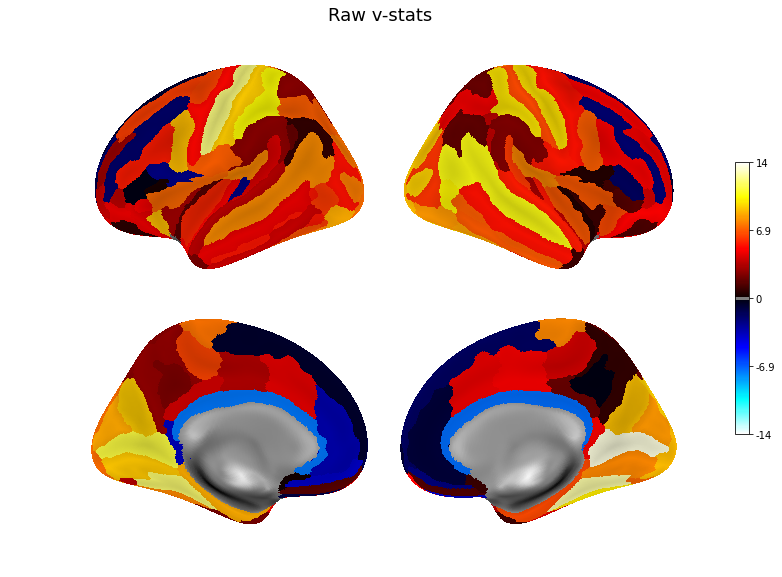

In [5]:
roi_names = list(data[thick])
v = to_vertex(original_scores, roi_names)
plot(v, title='Raw v-stats', threshold=.1)

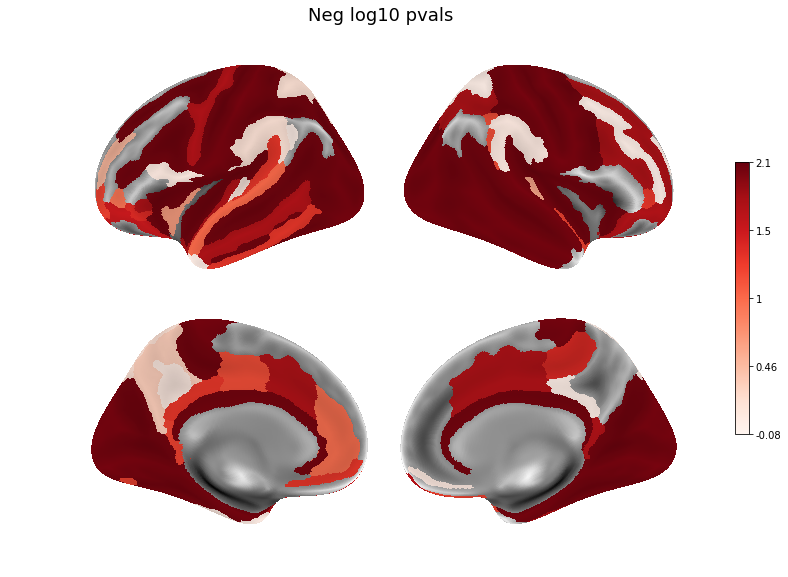

In [6]:
neg_log_pvals = -np.log10(pvals)
v = to_vertex(neg_log_pvals , roi_names)
plot(v, title='Neg log10 pvals', threshold=.001)

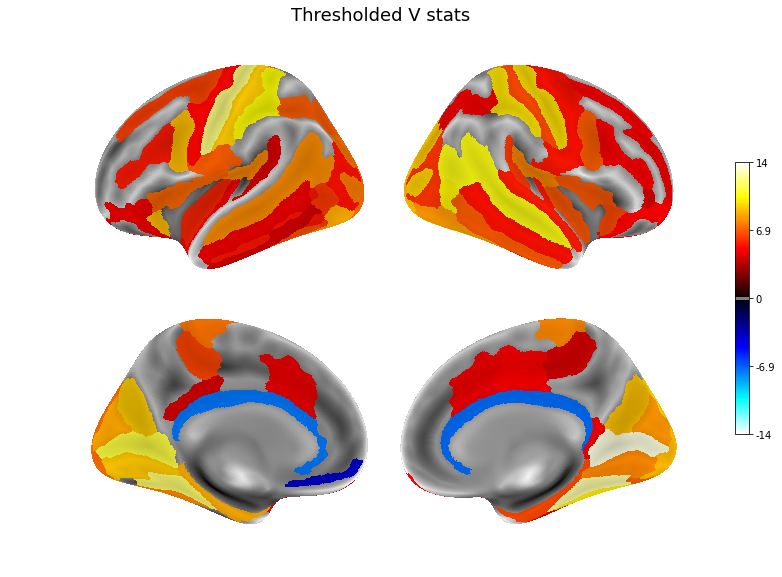

In [7]:
thresh_scores = original_scores.copy()
thresh_scores[pvals > .05] = 0

v = to_vertex(thresh_scores, roi_names)
plot(v, title='Thresholded V stats', threshold=.1)